In [213]:
using Turing 
using ReverseDiff
using TorusEvol
using StatsPlots
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
#Turing.setadbackend(:forwarddiff)
Turing.setprogress!(true)

@model function bisection_sampler_vec(p, descs, t)
    n = size(y, 2)
    D = length(descs)
    descs[1] ~ filldist(statdist(p), n)
    
    x = Matrix{Real}(undef, length(p), n)
    for i ∈ 1:n
        x[:, i] ~ transdist(p, t, vec(descs[1][:, i]))
        for d ∈ 2:D
            descs[d][:, i] ~ transdist(p, t, vec(x[:, i]))
        end
    end
end

@model function bisection_sampler(p, y, z, t)
    y ~ statdist(p)
    x ~ transdist(p, t, y)
    z ~ transdist(p, t, x)
end

[ Info: [Turing]: progress logging is enabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as true


bisection_sampler (generic function with 2 methods)

In [217]:
p = WrappedDiffusion(0.0, 0.0, 0.7, 0.7, 1.0, 1.0, 0.2)
t = 0.2
n = 100
x = rand(statdist(p), n)
x .= rand(statdist(p))

y = rand(transdist(p, t, x[:, 1]), n)
y .= rand(transdist(p, t, x[:, 1]))
z = rand(transdist(p, t, x[:, 1]), n)
z .= rand(transdist(p, t, x[:, 1]))
display(x[:, 1])
display(z[:, 1])
display(y[:, 1])

2-element Vector{Float64}:
 0.1851448822086531
 0.5806692342044998

2-element Vector{Float64}:
 0.7525059522084196
 0.4600516646883782

2-element Vector{Float64}:
 0.5228255705451168
 0.5163468693864253

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19


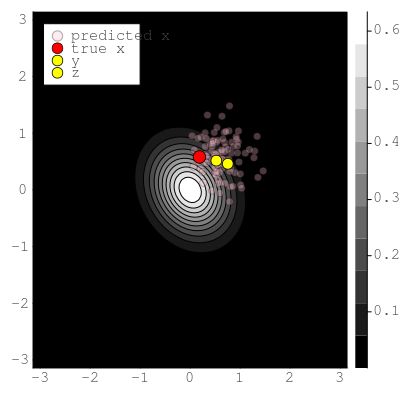

In [219]:
model = bisection_sampler_vec(p, [y, z], t)
mhs = MH(:x => v -> WrappedNormal.(v, Ref(I)))
hmc = HMC(0.05, 10, :x)
chn = sample(model, mhs, 100)
mean_x = reshape([mean(get(chn, :x).x[i]) for i ∈ 1:(2*n)], 2, :)

plt = contourf(grid, grid, f, xlims=(-π, π), ylims=(-π, π), fontfamily="JuliaMono", size=(400,400), levels=10, fill=false, label="stationary distribution", color=:bone)
scatter!(plt, mean_x[1,:], mean_x[2,:], label="predicted x", alpha=0.3, mc="pink")
scatter!(plt, [x[1]], [x[2]], mc="red", label="true x", ms=7)
scatter!(plt, [y[1]], [y[2]], mc="yellow", label="y", ms=6)
scatter!(plt, [z[1]], [z[2]], mc="yellow", label="z", ms=6)

In [182]:
p = WrappedDiffusion(0.0, 0.0, 0.7, 0.7, 1.0, 1.0, 0.2)
t = 0.1
n=4
x = rand(statdist(p), n)
ts = Vector{Any}(undef, n); transdist!(ts, p, t, x)
D = 2
descs = Vector{Any}(undef, D)
for d ∈ 1:D
    descs[d] = hcat(rand.(ts)...)
    print("descendant $d")
    display(descs[d])
end

print("ancestor")
display(x)

num_samples = 1000
burn_in = 500
model = bisection_sampler_vec(p, [y, z], t)
chn = sample(model, mhs, 10)
print("random predicted ancestor sample")
pred_x = reshape([get(chn, :x).x[i][end] for i ∈ 1:(2*n)], 2, :)
display(pred_x)

print("mean predicted ancestor")

mean_x = reshape([mean(get(chn, :x).x[i]) for i ∈ 1:(2*n)], 2, :)

descendant 1

2×4 Matrix{Float64}:
 -0.577736  -0.9338     0.735974   0.133129
  0.632869   0.831123  -0.668035  -0.491833

descendant 2

2×4 Matrix{Float64}:
 -0.671123  -0.820961   0.792131  -0.155273
  0.608967   0.456907  -0.580628  -0.567634

ancestor

2×4 Matrix{Float64}:
 -0.682919  -0.879359   0.480822   0.154832
  0.465581   0.691142  -0.616333  -0.525756

LoadError: DimensionMismatch: number of dimensions of `x` (1) must be greater than number of dimensions of `d` (2)

In [178]:
# continuous!!

num=10
p = jumping(WrappedDiffusion(2.0, 1.0, 0.7, 0.7, 0.1, 0.1, 0.05), 0.1)
x = [-2.0, -1.0]
t = 1.0
y = rand(transdist(p, t, x))
z = rand(transdist(p, t, x))
grid = range(-pi, pi, length=100)
f(x,y) = pdf(statdist(p), [x,y]);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


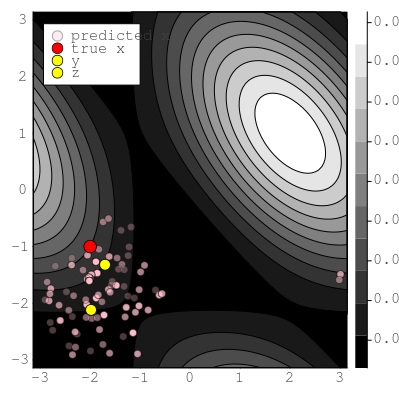

In [181]:
using LinearAlgebra
model = bisection_sampler(p, y, z, t)

mhs = MH(:x => v -> MixtureModel([WrappedNormal(v, I), WrappedNormal(v, 20*I)], [0.8, 0.2]))
hmcda = HMCDA(200, 0.65, 10.3, :x)
ch = sample(model, mhs, 1000)
plot(ch, fontfamily="JuliaMono")

pl = contourf(grid, grid, f, xlims=(-π, π), ylims=(-π, π), fontfamily="JuliaMono", size=(400,400), levels=10, fill=false, label="stationary distribution", color=:bone)
scatter!(pl, get(ch, :x).x[1][700:1000], get(ch, :x).x[2][700:1000], label="predicted x", alpha=0.3, mc="pink")
scatter!(pl, [x[1]], [x[2]], mc="red", label="true x", ms=7)
scatter!(pl, [y[1]], [y[2]], mc="yellow", label="y", ms=6)
scatter!(pl, [z[1]], [z[2]], mc="yellow", label="z", ms=6)
savefig("images/sample_dihedral_ancestor.svg")
display(pl)

[ Info: 10
[ Info: 10
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


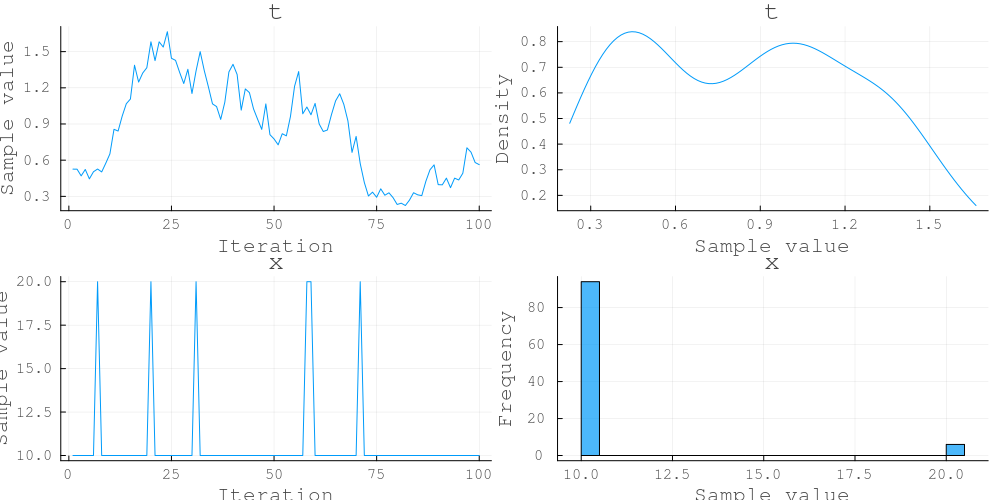

In [26]:
# discrete!!

x = 10
p = WAG_SubstitutionProcess
t = 0.2

y = rand(transdist(p, t/2, x))
@info y

z = rand(transdist(p, t/2, x))
@info z

model = bisection_sampler(p, y, z)
ch = sample(model, Gibbs(HMC(0.03, 5, :t), PG(100, :x)), 100)
plot(ch, fontfamily="JuliaMono")